In [28]:
import pandas as pd
import scanpy as sc
from warnings import filterwarnings
filterwarnings('ignore')
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm

### Gather performance and plotting

This script is to plot the prediction performance of different models and save the performance into a csv file for later reference. 

In [29]:
config = {
    "dataset": "norman_k562",
    "use_hvg": True,
    "dataset_name": "norman_k562_hvg",
    "include_moe": False,
    "test_set_name": "5_fold_split", # "out_of_distribution_split" or "5_fold_split"
    "null_label": "zeros",
    "epochs": 100,
    "tolerance_epoch": 20,
    "val_ratio": 0.1,
    "ood_ratio": 0.15,
    "latdim_ctrl": 50,
    "latdim_ptb": 50,
    "geneset_num": 50,
    "mxAlpha": 2.0,
    "prior_list": [
        "Control_Gene_Expression",
        "DepMap_GeneEffect",
        "Geneformer",
        "GenePT_v1",
        "GenePT_v2_large",
        "STRING"
    ],
    "model_type": "mvae_attention_vae_14_3"
}

In [30]:
if config['test_set_name'] == '5_fold_split':
    if config['dataset'] == 'norman_k562':
         test_set_ids = ['random_split_1_2', 'random_split_2_2', 'random_split_3_2', 'random_split_4_2', 'random_split_5_2']
    else:
        test_set_ids = ['random_fold_1', 'random_fold_2', 'random_fold_3', 'random_fold_4', 'random_fold_5']
    random_seeds = [12]
elif config['test_set_name'] == 'out_of_distribution_split':
    test_set_ids = ['out_of_distribution']
    random_seeds = [8, 9, 10, 11, 12]

### Step 1. Read in all results in csv

In [31]:
gears_path = f"/home/che/GEARS/{config['dataset_name']}"
vae_attention_path = f"/home/che/perturb-project/predict_model/result/rna/{config['dataset_name']}"
linear_model_path = f"/home/che/perturb-project/git/gene_ptb_prediction/baseline_model/linear_model/{config['dataset_name']}_results.csv"
control_distribution_path = f"/home/che/perturb-project/git/gene_ptb_prediction/baseline_model/predict_control/{config['dataset_name']}_results.csv"

In [32]:
linear_model_df = pd.read_csv(linear_model_path)
linear_model_df = linear_model_df[linear_model_df['random_seed'].isin(random_seeds)]
linear_model_df = linear_model_df[linear_model_df['test_set_id'].isin(test_set_ids)]
# rename model_type to be 
linear_model_df['model_type'] = 'Linear'

In [33]:
control_distribution_df = pd.read_csv(control_distribution_path)
control_distribution_df = control_distribution_df[control_distribution_df['random_seed'].isin(random_seeds)]
control_distribution_df = control_distribution_df[control_distribution_df['test_set_id'].isin(test_set_ids)]

In [34]:
gears_df = pd.DataFrame()
vae_attention_best_model_df = pd.DataFrame()
vae_attention_best_model_val_df = pd.DataFrame()


for test_set_id in test_set_ids:

    # load in GEARS results
    for random_seed in random_seeds:
        gears_path_temp = f'{gears_path}/{test_set_id}/random_seed_{random_seed}/summary_evaluations.csv'
        gears_df_temp = pd.read_csv(gears_path_temp)
        gears_df = pd.concat([gears_df, gears_df_temp])

    # load in VAE attention results
    for random_seed in random_seeds:
        vae_attention_path_parent_temp = (f"{vae_attention_path}/latdim_ctrl_{config['latdim_ctrl']}_latdim_ptb_{config['latdim_ptb']}_geneset_num_{config['geneset_num']}/{test_set_id}/"
                                    f"recon_loss_mmd/null_label_{config['null_label']}/epochs_{config['epochs']}/"
                                    f"tolerance_epochs_{config['tolerance_epoch']}/mxAlpha_{config['mxAlpha']}/"
                                    f"val_{config['val_ratio']}_ood_{config['ood_ratio']}/random_seed_{random_seed}")
        for prior in config['prior_list']:
            pattern = f"{vae_attention_path_parent_temp}/{prior}_{config['model_type']}_run*"
            vae_attention_path_temp = glob.glob(pattern)
            assert len(vae_attention_path_temp) == 1, f'Error: {pattern}'
            vae_attention_path_temp = vae_attention_path_temp[0]
            vae_attention_best_model_df_temp = pd.read_csv(f'{vae_attention_path_temp}/best_model_summary_evaluations.csv')
            vae_attention_best_model_val_df_temp = pd.read_csv(f'{vae_attention_path_temp}/best_model_val_summary_evaluations.csv')
            vae_attention_best_model_df = pd.concat([vae_attention_best_model_df, vae_attention_best_model_df_temp])
            vae_attention_best_model_val_df = pd.concat([vae_attention_best_model_val_df, vae_attention_best_model_val_df_temp])

        if config['include_moe']:
            moe_model_type = 'mvae_attention_vae_14_3_moe_3expert'
            pattern = f'{vae_attention_path_parent_temp}/DepMap_GeneEffect_{moe_model_type}_run*'
            vae_attention_path_temp = glob.glob(pattern)
            assert len(vae_attention_path_temp) == 1, f'Error: {pattern}'
            vae_attention_path_temp = vae_attention_path_temp[0]
            vae_attention_best_model_df_temp = pd.read_csv(f'{vae_attention_path_temp}/best_model_summary_evaluations.csv')
            vae_attention_best_model_val_df_temp = pd.read_csv(f'{vae_attention_path_temp}/best_model_val_summary_evaluations.csv')
            vae_attention_best_model_df = pd.concat([vae_attention_best_model_df, vae_attention_best_model_df_temp])
            vae_attention_best_model_val_df = pd.concat([vae_attention_best_model_val_df, vae_attention_best_model_val_df_temp])

assert gears_df.shape[0] == linear_model_df.shape[0] == control_distribution_df.shape[0] == len(test_set_ids) * len(random_seeds)
if config['include_moe']:
    assert vae_attention_best_model_df.shape[0] == vae_attention_best_model_val_df.shape[0] == len(test_set_ids) * len(config['prior_list']) * len(random_seeds) + len(test_set_ids) * len(random_seeds)
else:
    assert vae_attention_best_model_df.shape[0] == vae_attention_best_model_val_df.shape[0] == len(test_set_ids) * len(config['prior_list']) * len(random_seeds)

### Step 2. Put results together in one table and save as a csv file

In [35]:
columns_selected = ['random_seed', 'data', 'test_set_id', 'model_type', 'label_1', 'mmd', 'r2', 'rmse', 'rmse_change', 'pearsonr_change', 'fraction', 'model_path']

In [36]:
use_val = False
if use_val:
    all_results_df = pd.concat([gears_df[columns_selected], 
                                linear_model_df[columns_selected], 
                                control_distribution_df[columns_selected], 
                                vae_attention_best_model_val_df[columns_selected]], axis=0)
else:
    all_results_df = pd.concat([gears_df[columns_selected], 
                                linear_model_df[columns_selected], 
                                control_distribution_df[columns_selected], 
                                vae_attention_best_model_df[columns_selected]], axis=0)

all_results_df.head(2)

,random_seed,data,test_set_id,model_type,label_1,mmd,r2,rmse,rmse_change,pearsonr_change,fraction,model_path
0,12.0,norman_k562_hvg,random_split_1_2,Gears,NaN,0.628289,0.845029,0.225164,0.225164,0.695138,0.599740,/home/che/GEARS/norman_k562_hvg/random_split_1...
0,12.0,norman_k562_hvg,random_split_2_2,Gears,NaN,0.728961,0.849139,0.265641,0.265641,0.467878,0.563429,/home/che/GEARS/norman_k562_hvg/random_split_2...


In [37]:
all_results_df['model_name'] = all_results_df.apply(lambda row: f"{row['model_type']}\n({row['label_1']})" if pd.notnull(row['label_1']) else row['model_type'], axis=1)

# clean names
all_results_df['model_name'] = all_results_df['model_name'].str.replace('mvae_attention_vae_14_3_moe_3expert', 'MOE', regex=False)
all_results_df['model_name'] = all_results_df['model_name'].str.replace('mvae_attention_vae_14_3', 'MORPH', regex=False)
all_results_df['model_name'] = all_results_df['model_name'].str.replace('DepMap_GeneEffect', 'DepMap', regex=False)
all_results_df['model_name'] = all_results_df['model_name'].str.replace('Control_Gene_Expression', 'Control\ngene expression', regex=False)
all_results_df['model_name'] = all_results_df['model_name'].str.replace('GenePT_v1', 'GenePT\n(NCBI)', regex=False)
all_results_df['model_name'] = all_results_df['model_name'].str.replace('GenePT_v2_large', 'GenePT\n(NCBI+UniProt)', regex=False)
all_results_df['model_name'] = all_results_df['model_name'].str.replace('STRING', 'GPT\n(STRING)', regex=False)
all_results_df['model_name'] = all_results_df['model_name'].str.replace('Control distribution', 'Control\ndistribution', regex=False)
all_results_df['model_name'] = all_results_df['model_name'].str.replace('MOE\n(DepMap)', 'MOE\n(DepMap+\nNCBI+\nSTRING)', regex=False)
all_results_df['model_name'] = all_results_df['model_name'].str.replace('Gears', 'GEARS', regex=False)
all_results_df.head(2)

,random_seed,data,test_set_id,model_type,label_1,mmd,r2,rmse,rmse_change,pearsonr_change,fraction,model_path,model_name
0,12.0,norman_k562_hvg,random_split_1_2,Gears,NaN,0.628289,0.845029,0.225164,0.225164,0.695138,0.599740,/home/che/GEARS/norman_k562_hvg/random_split_1...,GEARS
0,12.0,norman_k562_hvg,random_split_2_2,Gears,NaN,0.728961,0.849139,0.265641,0.265641,0.467878,0.563429,/home/che/GEARS/norman_k562_hvg/random_split_2...,GEARS


In [38]:
subset_df = all_results_df[all_results_df['label_1'] == 'DepMap_GeneEffect']
print(subset_df.shape)
subset_df[subset_df['model_type'] == 'mvae_attention_vae_14_3']['mmd'].mean()

(10, 13)


0.4439993694160539

In [39]:
# save into a csv file 
result_folder = f"{config['dataset_name']}"
result_folder += f"/{config['test_set_name']}"
result_folder += f"/random_seed_{random_seed}"
result_folder += f"/null_label_{config['null_label']}"
result_folder += f"/tolerance_epoch_{config['tolerance_epoch']}"
if use_val:
    result_folder += '/best_model_val'
else:
    result_folder += '/best_model'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)
print(result_folder)

all_results_df.to_csv(f'{result_folder}/results.csv', index=False)

norman_k562_hvg/5_fold_split/random_seed_12/null_label_zeros/tolerance_epoch_20/best_model


In [40]:
import json
config['random_seeds'] = random_seeds
config['test_set_ids'] = test_set_ids
config['use_val'] = use_val
with open(f"{result_folder}/boxplot_config.json", "w") as f:
    json.dump(config, f, indent=4)

### Step 3. Plot results

In [41]:
all_results_df['test_set_id'].unique()

array(['random_split_1_2', 'random_split_2_2', 'random_split_3_2',
       'random_split_4_2', 'random_split_5_2'], dtype=object)

In [42]:
all_results_df['random_seed'].unique()

array([12.])

In [43]:
control_distribution_df['mmd'].mean(), gears_df['mmd'].mean(), linear_model_df['mmd'].mean()

(1.041540258159727, 0.659199609621601, 0.6281548827869181)

In [44]:
control_distribution_df['mmd'].std(), gears_df['mmd'].std(), linear_model_df['mmd'].std()

(0.07284479638376463, 0.04052135858567451, 0.03876028888864264)

In [45]:
grouped_data = all_results_df.groupby("model_name").agg(
    mmd_mean=("mmd", "mean"),
    mmd_std=("mmd", "std"),
    r2_mean=("r2", "mean"),
    r2_std=("r2", "std"),
    rmse_mean=("rmse", "mean"),
    rmse_std=("rmse", "std"),
    rmse_change_mean=("rmse_change", "mean"),
    rmse_change_std=("rmse_change", "std"),
    pearsonr_change_mean=("pearsonr_change", "mean"),
    pearsonr_change_std=("pearsonr_change", "std"),
    fraction_mean=("fraction", "mean"),
    fraction_std=("fraction", "std"),
    mmd_values=("mmd", lambda x: list(x)),
    r2_values=("r2", lambda x: list(x)),
    rmse_values=("rmse", lambda x: list(x)),
    rmse_change_values=("rmse_change", lambda x: list(x)),
    pearsonr_change_values=("pearsonr_change", lambda x: list(x)),
    fraction_values=("fraction", lambda x: list(x)),
).reset_index()
grouped_data

,model_name,mmd_mean,mmd_std,r2_mean,r2_std,rmse_mean,rmse_std,rmse_change_mean,rmse_change_std,pearsonr_change_mean,pearsonr_change_std,fraction_mean,fraction_std,mmd_values,r2_values,rmse_values,rmse_change_values,pearsonr_change_values,fraction_values
0,Control\ndistribution,1.041540,0.072845,0.792292,0.032314,0.372830,0.023160,0.372830,0.023160,0.009252,0.019229,0.522814,0.007907,"[1.0482013861114172, 0.9577325752224196, 1.153...","[0.7365747460821472, 0.795605648060406, 0.8010...","[0.3776128, 0.3465689122676849, 0.408061295747...","[0.3776128, 0.3465689122676849, 0.408061295747...","[0.0105737947110637, -0.0103423004768037, 0.04...","[0.5230952380952381, 0.512054794520548, 0.5192..."
1,GEARS,0.659200,0.040521,0.880890,0.032363,0.238373,0.016865,0.238373,0.016865,0.651955,0.110641,0.602249,0.031533,"[0.62828933181117, 0.7289605906945035, 0.65795...","[0.8450291221392396, 0.8491387443552325, 0.916...","[0.22516415, 0.26564077, 0.23892634, 0.2385690...","[0.22516415, 0.26564077, 0.23892634, 0.2385690...","[0.695138464238511, 0.4678775493943838, 0.7533...","[0.5997402597402597, 0.5634285714285716, 0.646..."
2,Linear\n(DepMap),0.628155,0.038760,0.885293,0.029683,0.228271,0.012304,0.228271,0.012304,0.661464,0.043617,0.701953,0.012191,"[0.6660969133379095, 0.5677893779160021, 0.636...","[0.8384881881897606, 0.878887035771038, 0.9181...","[0.240387212808804, 0.207768686865531, 0.23021...","[0.2403872130022019, 0.2077686864980994, 0.230...","[0.6585906725689575, 0.6147058314298262, 0.726...","[0.6962025316455697, 0.6917808219178082, 0.722..."
3,MORPH\n(Control\ngene expression),0.464742,0.032300,0.902069,0.037489,0.184851,0.013746,0.184851,0.013746,0.757167,0.059216,0.772343,0.015039,"[0.5053705453075503, 0.4269373008730788, 0.481...","[0.8418041224467704, 0.9003893701967358, 0.938...","[0.2026765209894337, 0.1709339358050704, 0.192...","[0.2026765206781233, 0.1709339354712288, 0.192...","[0.6923765581181671, 0.7218338176497612, 0.848...","[0.7597500000000001, 0.7619444444444444, 0.797..."
4,MORPH\n(DepMap),0.443999,0.025907,0.911635,0.032730,0.177943,0.011322,0.177943,0.011322,0.756167,0.039789,0.782956,0.017775,"[0.4829197312616607, 0.41562637598796, 0.45072...","[0.8602149609647515, 0.9001843837859608, 0.943...","[0.1915494085033715, 0.1684773335578396, 0.187...","[0.1915494080962938, 0.16847733322775, 0.18770...","[0.7231937598834637, 0.714044485221148, 0.8127...","[0.7820253164556961, 0.7605714285714287, 0.799..."
5,MORPH\n(GPT\n(STRING)),0.442049,0.020432,0.911697,0.028095,0.176897,0.010823,0.176897,0.010823,0.786538,0.035804,0.790503,0.022064,"[0.4503248441934325, 0.4164680325263065, 0.467...","[0.8683340206380341, 0.9015328130994772, 0.939...","[0.1805564134212467, 0.1680071629773337, 0.192...","[0.1805564130938875, 0.1680071626934788, 0.192...","[0.7627466973423168, 0.7503966756278564, 0.839...","[0.7612500000000001, 0.7905555555555556, 0.816..."
6,MORPH\n(GenePT\n(NCBI)),0.446799,0.024487,0.911546,0.029042,0.179458,0.013283,0.179458,0.013283,0.780345,0.042841,0.785836,0.015185,"[0.4633780337876474, 0.4061821239077309, 0.467...","[0.8676822493960731, 0.897463851794378, 0.9394...","[0.1870639656843511, 0.1621942139181088, 0.196...","[0.1870639653146093, 0.1621942135343299, 0.196...","[0.7369964975546905, 0.7424439288609256, 0.841...","[0.7659523809523809, 0.7767123287671233, 0.805..."
7,MORPH\n(GenePT\n(NCBI+UniProt)),0.436184,0.023051,0.912474,0.033207,0.174924,0.011894,0.174924,0.011894,0.774540,0.053253,0.788869,0.007571,"[0.4719376130768105, 0.408280035579172, 0.4371...","[0.8616356942439489, 0.8978636040503075, 0.944...","[0.1898104044456282, 0.1619922368975937, 0.182...","[0.1898104042316547, 0.1619922365642841, 0.182...","[0.7132920945620651, 0.7252024411791501, 0.838...","[0.7871428571428571, 0.7805479452054794, 0.798..."
8,MORPH\n(Geneformer),0.445800,0.037445,0.907851,0.032941,0.181023,0.013948,0.181023,0.013948,0.762024,0.062406,0.785221,0.022838,"[0.4817371252634598, 0.3915968949135202, 0.429...","[0.858558256

In [46]:
grouped_data.to_csv(f'{result_folder}/sumamry_results.csv', index=False)

In [47]:
desired_order_baseline = [ 'Control\ndistribution', 'GEARS', 'Linear\n(DepMap)',  'MORPH\n(DepMap)']
if config['include_moe']:
    desired_order_priors = ['Control\ngene expression','Geneformer', 'GenePT\n(NCBI)', 'GenePT\n(NCBI+UniProt)', 'GPT\n(STRING)', 'DepMap', 'MOE\n(DepMap+\nNCBI+\nSTRING)']
else:
    desired_order_priors = ['Control\ngene expression','Geneformer', 'GenePT\n(NCBI)', 'GenePT\n(NCBI+UniProt)', 'GPT\n(STRING)', 'DepMap']
plot_types = ['compare_priors', 'compare_baselines']

### Plot MMD (distribution loss)

In [48]:
model_colors_baseline = {
            'Control\ndistribution': 'darkgrey',
            'GEARS': '#6baed6',
            'Linear\n(DepMap)': '#9e9ac8',
            'MORPH\n(DepMap)': '#74c476',
        }

model_colors_prior = {
            'Control\ngene expression': '#b9e1ba',
            'Geneformer': '#abdbac',
            'GenePT\n(NCBI)': '#9dd59f',
            'GenePT\n(NCBI+UniProt)': '#8fcf91',
            'GPT\n(STRING)': '#81c983',
            'DepMap': '#74c476',
            'MOE\n(DepMap+\nNCBI+\nSTRING)': '#66bf69',
        }

In [49]:
np.random.seed(0)
jiggers = np.random.normal(0, 0.05, size=len(grouped_data['mmd_values'].values[0]))
jiggers

array([0.08820262, 0.02000786, 0.0489369 , 0.11204466, 0.0933779 ])

In [50]:
# set mmd_mean, mmd_std, and mmd_values to 0 for Linear\n(DepMap)
grouped_data.loc[grouped_data['model_name'] == 'Linear\n(DepMap)', 'mmd_mean'] = -1
grouped_data.loc[grouped_data['model_name'] == 'Linear\n(DepMap)', 'mmd_std'] = 0

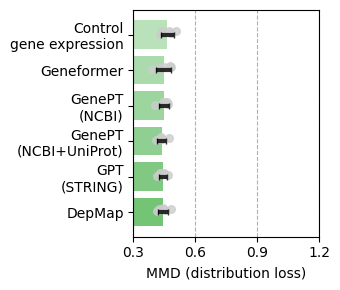

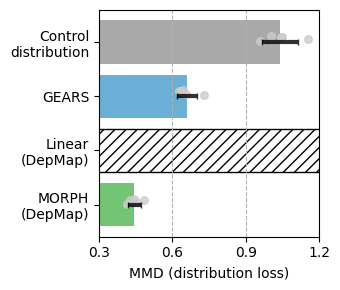

In [51]:
from matplotlib.patches import Rectangle
for plot_type in plot_types:
    # Simplified bar plot for MMD
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.size'] = 10

    # Prepare the DataFrame for MMD
    mmd_df = grouped_data.dropna(subset=['mmd_mean'])
    if plot_type == 'compare_baselines':
        desired_order = desired_order_baseline
        model_colors = model_colors_baseline
    elif plot_type == 'compare_priors':
        # subset and rename the model names
        mmd_df = mmd_df[mmd_df['model_name'].str.contains('MORPH|MOE')]
        mmd_df['model_name'] = mmd_df['model_name'].str.replace(r"MORPH\n\(([^)]*)\)", r"\1", regex=True)
        desired_order = desired_order_priors
        model_colors = model_colors_prior
    mmd_df = mmd_df[mmd_df['model_name'].isin(desired_order)]
    mmd_df['model_name'] = pd.Categorical(mmd_df['model_name'], categories=desired_order[::-1], ordered=True)
    mmd_df = mmd_df.sort_values('model_name')

    # Customize x-axis limits and ticks based on dataset
    if config['include_moe']:
        fig_x = 4
        fig_y = 4
    else:
        fig_x = 3.5
        fig_y = 3
        bar_width = 0.8
    if config['dataset_name'] == 'norman_k562_hvg':
        if config['test_set_name'] == '5_fold_split':
            x_min = 0.3
            x_max = 1.2

    # Draw figure
    fig, ax = plt.subplots(figsize=(fig_x, fig_y))
    indices = np.arange(len(mmd_df))
    colors = mmd_df['model_name'].map(model_colors)

    # Plot bars for MMD with individual colors
    # ax.barh(indices, mmd_df['mmd_mean'],color=colors, zorder = 1)
    # Plot horizontal bars
    for idx, (mean, color) in enumerate(zip(mmd_df['mmd_mean'], colors)):
        if mean > 0:
            ax.barh(idx, mean, color=color, zorder=1)
        else:
            # Add rectangle with diagonal hatching for NA
            rect = Rectangle(
                (0, idx - 0.4),  # Bottom-left corner (start of rectangle)
                2,             # length of rectangle
                bar_width,       # bar width
                facecolor='none',  # Transparent fill
                edgecolor='black', # Border color
                linewidth=1,
                hatch='///'        # Diagonal lines
            )
            ax.add_patch(rect)

    # Plot individual dots for each MMD value
    for i, model_name in enumerate(mmd_df['model_name']):
        if model_name == 'Linear\n(DepMap)':
            continue
        model_values = mmd_df[mmd_df['model_name'] == model_name]['mmd_values'].values[0]
        jittered_y = indices[i] + jiggers  # Adjust the jitter level as needed
        ax.scatter(model_values, jittered_y, color='#cccccc', alpha=0.8, s=30, zorder=2)
    # Plot error bars for MMD on top (top layer)
    ax.errorbar(mmd_df['mmd_mean'], indices, xerr=mmd_df['mmd_std'], fmt='none', 
                ecolor='black', elinewidth=3, capsize=2, zorder=3, alpha=0.8)

    # Set ticks and labels
    ax.set_yticks(indices)
    ax.set_yticklabels(mmd_df['model_name'])
    ax.set_xlabel('MMD (distribution loss)')
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(np.round(np.linspace(x_min, x_max, 4), 2))
    ax.grid(False, axis='x', linestyle='--')
    
    # Save plot
    plt.tight_layout()
    if config['include_moe']:
        plt.savefig(f'{result_folder}/{plot_type}_mmd_plot_moe.png', dpi=300)
        # save svg format
        plt.savefig(f'{result_folder}/{plot_type}_mmd_plot_moe.svg', format='svg')
    else:
        plt.savefig(f'{result_folder}/{plot_type}_mmd_plot.png', dpi=300)
        # save svg format
        plt.savefig(f'{result_folder}/{plot_type}_mmd_plot.svg', format='svg')
        plt.show()

### Plot RMSE (feature means)

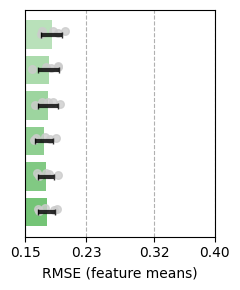

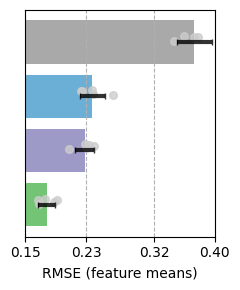

In [52]:
for plot_type in plot_types:
    # Simplified bar plot for rmse
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.size'] = 10

    # Prepare the DataFrame for rmse
    rmse_df = grouped_data.dropna(subset=['rmse_mean'])
    if plot_type == 'compare_baselines':
        desired_order = desired_order_baseline
        model_colors = model_colors_baseline
    elif plot_type == 'compare_priors':
        # subset and rename the model names
        rmse_df = rmse_df[rmse_df['model_name'].str.contains('MORPH')]
        rmse_df['model_name'] = rmse_df['model_name'].str.replace(r"MORPH\n\(([^)]*)\)", r"\1", regex=True)
        desired_order = desired_order_priors
        model_colors = model_colors_prior
    rmse_df = rmse_df[rmse_df['model_name'].isin(desired_order)]
    rmse_df['model_name'] = pd.Categorical(rmse_df['model_name'], categories=desired_order[::-1], ordered=True)
    rmse_df = rmse_df.sort_values('model_name')

    # Customize x-axis limits and ticks based on dataset
    fig_x = 2.5
    fig_y = 3
    if config["dataset_name"] == 'norman_k562_hvg':
        if config["test_set_name"] == '5_fold_split':
            x_min=0.15
            x_max=0.4

    # Set up figure
    fig, ax = plt.subplots(figsize=(fig_x, fig_y))

    # Set bar width
    indices = np.arange(len(rmse_df))
    colors = rmse_df['model_name'].map(model_colors)

    # Plot bars
    ax.barh(indices, rmse_df['rmse_mean'],color=colors, zorder = 1)
    # Plot individual dots
    for i, model_name in enumerate(rmse_df['model_name']):
        model_values = rmse_df[rmse_df['model_name'] == model_name]['rmse_values'].values[0]
        jittered_y = indices[i] + jiggers
        ax.scatter(model_values, jittered_y, color='#cccccc', alpha=0.8, s=30, zorder=2)
    # Plot error bars
    ax.errorbar(rmse_df['rmse_mean'], indices, xerr=rmse_df['rmse_std'], fmt='none', 
                ecolor='black', elinewidth=3, capsize=2, zorder=3, alpha=0.8)

    # Set ticks and labels
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xlabel('RMSE (feature means)')
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(np.round(np.linspace(x_min, x_max, 4), 2))
    ax.grid(False, axis='x', linestyle='--')

    # Save plot
    plt.tight_layout()
    plt.savefig(f'{result_folder}/{plot_type}_rmse_plot.png', dpi=300)
    # save svg format
    plt.savefig(f'{result_folder}/{plot_type}_rmse_plot.svg', format='svg')
    plt.show()

### Plot pearson correlation with true change in expression (top 50 de genes)

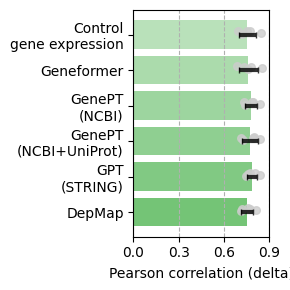

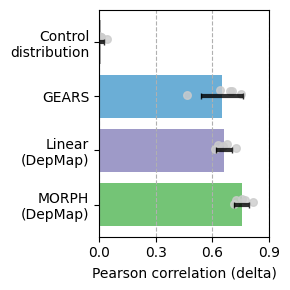

In [53]:
for plot_type in plot_types:
    # Simplified bar plot for MMD
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.size'] = 10

    # Prepare the DataFrame for MMD
    plot_df = grouped_data.dropna(subset=['pearsonr_change_mean'])
    if plot_type == 'compare_baselines':
        desired_order = desired_order_baseline
        model_colors = model_colors_baseline
    elif plot_type == 'compare_priors':
        # subset and rename the model names
        plot_df = plot_df[plot_df['model_name'].str.contains('MORPH')]
        plot_df['model_name'] = plot_df['model_name'].str.replace(r"MORPH\n\(([^)]*)\)", r"\1", regex=True)
        desired_order = desired_order_priors
        model_colors = model_colors_prior
    plot_df = plot_df[plot_df['model_name'].isin(desired_order)]
    plot_df['model_name'] = pd.Categorical(plot_df['model_name'], categories=desired_order[::-1], ordered=True)
    plot_df = plot_df.sort_values('model_name')

    # Customize x-axis limits and ticks based on dataset
    fig_x = 3
    fig_y = 3
    if config['dataset_name'] == 'norman_k562_hvg':
        if config['test_set_name'] == '5_fold_split':
            x_min = 0
            x_max = 0.9

    # Set up figure
    fig, ax = plt.subplots(figsize=(fig_x, fig_y))

    # Set bar width
    indices = np.arange(len(plot_df))
    colors = plot_df['model_name'].map(model_colors)

    # Plot bars
    ax.barh(indices, plot_df['pearsonr_change_mean'],color=colors, zorder = 1)
    # Plot individual dots
    for i, model_name in enumerate(plot_df['model_name']):
        model_values = plot_df[plot_df['model_name'] == model_name]['pearsonr_change_values'].values[0]
        jittered_y = indices[i] + jiggers
        ax.scatter(model_values, jittered_y, color='#cccccc', alpha=0.8, s=30, zorder=2)
    # Plot error bars
    ax.errorbar(plot_df['pearsonr_change_mean'], indices, xerr=plot_df['pearsonr_change_std'], fmt='none', 
                ecolor='black', elinewidth=3, capsize=2, zorder=3, alpha=0.8)

    # Set ticks and labels
    ax.set_yticks(indices)
    ax.set_yticklabels(plot_df['model_name'])
    # ax.set_yticks([])
    # ax.set_yticklabels([])
    ax.set_xlabel(r'Pearson correlation (delta)')
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(np.round(np.linspace(x_min, x_max, 4), 2))
    ax.grid(False, axis='x', linestyle='--')

    # Save plot
    plt.tight_layout()
    plt.savefig(f'{result_folder}/{plot_type}_pearsonr_change_plot.png', dpi=300)
    # save svg format
    plt.savefig(f'{result_folder}/{plot_type}_pearsonr_change_plot.svg', format='svg')
    plt.show()

### Plot fraction of top 50 DE genes with true direction

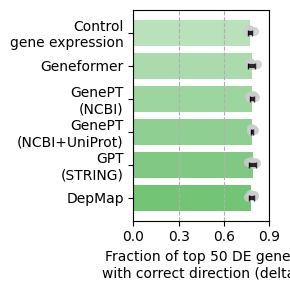

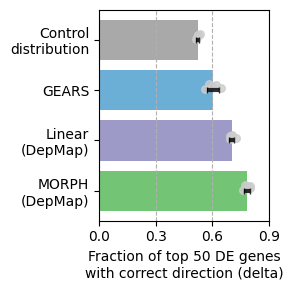

In [54]:
for plot_type in plot_types:
    # Simplified bar plot for MMD
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.size'] = 10

    # Prepare the DataFrame for MMD
    plot_df = grouped_data.dropna(subset=['fraction_mean'])
    if plot_type == 'compare_baselines':
        desired_order = desired_order_baseline
        model_colors = model_colors_baseline
    elif plot_type == 'compare_priors':
        # subset and rename the model names
        plot_df = plot_df[plot_df['model_name'].str.contains('MORPH')]
        plot_df['model_name'] = plot_df['model_name'].str.replace(r"MORPH\n\(([^)]*)\)", r"\1", regex=True)
        desired_order = desired_order_priors
        model_colors = model_colors_prior
    plot_df = plot_df[plot_df['model_name'].isin(desired_order)]
    plot_df['model_name'] = pd.Categorical(plot_df['model_name'], categories=desired_order[::-1], ordered=True)
    plot_df = plot_df.sort_values('model_name')

    # Customize x-axis limits and ticks based on dataset
    fig_x = 3
    fig_y = 3
    if config['dataset_name'] == 'norman_k562_hvg':
        if config['test_set_name'] == '5_fold_split':
            x_min = 0
            x_max = 0.9

    # Set up figure
    fig, ax = plt.subplots(figsize=(fig_x, fig_y))

    # Set bar width
    indices = np.arange(len(plot_df))
    colors = plot_df['model_name'].map(model_colors)

    # Plot bars
    ax.barh(indices, plot_df['fraction_mean'],color=colors, zorder = 1)
    # Plot individual dots
    for i, model_name in enumerate(plot_df['model_name']):
        model_values = plot_df[plot_df['model_name'] == model_name]['fraction_values'].values[0]
        jittered_y = indices[i] + jiggers  # Adjust the jitter level as needed
        ax.scatter(model_values, jittered_y, color='#cccccc', alpha=0.8, s=30, zorder=2)
    # Plot error bars
    ax.errorbar(plot_df['fraction_mean'], indices, xerr=plot_df['fraction_std'], fmt='none', 
                ecolor='black', elinewidth=3, capsize=2, zorder=3, alpha=0.8)

    # Set ticks and labels
    ax.set_yticks(indices)
    ax.set_yticklabels(plot_df['model_name'])
    ax.set_xlabel('Fraction of top 50 DE genes\nwith correct direction (delta)')
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(np.round(np.linspace(x_min, x_max, 4), 2))
    ax.grid(False, axis='x', linestyle='--')

    # Save plot
    plt.tight_layout()
    plt.savefig(f'{result_folder}/{plot_type}_fraction_change_plot.png', dpi=300)
    # save svg format
    plt.savefig(f'{result_folder}/{plot_type}_fraction_change_plot.svg', format='svg')
    plt.show()